<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# Deep Q-Network <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a>

In this chapter we will extend Q-learning algorithm in tabular form to problems with continuous states via (state/action) value function approximation.

<img src="images/dqn_alg.png" width=600 />
<center> DQN algorithm from original <a href="https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf">[paper]</a></center>

As you can see wee need to implement couple of things.

1. Neural Network
2. Epsilon Greedy agent that will use the Network for exploitation phase
3. Experience Replay for training the network

First we will define the neural network architecture and its training procedure. Then we implement Experience Replay and then we move to the functionality of the agent.

In [12]:
# ONLY RUN THIS CELL FROM GOOGLE COLAB
!git clone https://github.com/illyakaynov/masterclass-drl-wur
import sys
sys.path.append('/content/masterclass-drl-wur')

!pip install 'gym[box2d]'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip
!apt-get install ffmpeg -y

ERROR: Invalid requirement: "'gym[box2d]'"
'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt' is not recognized as an internal or external command,
operable program or batch file.


  Using cached https://github.com/pyglet/pyglet/archive/pyglet-1.5-maintenance.zip


'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

def set_gpu(idxs=None):
    """Set visible GPUs
    ids: list of GPU ids to be visible, None to disble all GPUs
    """
    import tensorflow as tf
    gpu_devices = [x for x in tf.config.list_physical_devices() if x.device_type=='GPU']
    
    idxs = idxs or []
    set_visible = [gpu_devices[idx] for idx in idxs]
    
    try:
        # Disable all GPUS
        tf.config.set_visible_devices(set_visible, 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    finally:
        print(tf.config.get_visible_devices())
        
# Disable GPUs        
set_gpu(idxs=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Network

## Replay Buffer

We might be tempted to perform gradient update every time we have a new batch of observations ready. However, the several consequent observations are dependent on each other. This correlation breaks the qualification for stochastic gradient descent, since one of the assumption is that the batch data is i.i.d. sample from a certain distribution. In order to break this correlation we are going to use Experience Replay. First we collect the experiences in a buffer, then we sample a batch from it and perform a gradient update. We also include 3 of the most recent observations in the sample to make sure that the training is performed on each of the observations at least once. It is very convenient and fast to use a ```collections.deque``` for this. This standard Python data-structure can maintain fixed length by removing the oldest elements when the capacity is reached.

In [2]:
import random

from collections import deque

import numpy as np


class ReplayBuffer:
    def __init__(self, replay_capacity=50000, include_last_samples=3):
        """
        Simple replay buffer based on the collections.deque
        :param replay_capacity: the size of the buffer, i.e. the number of last transitions to save
        :param include_last_samples: include a number of most recent observations into a sample batch
        """
        self.replay_capacity = replay_capacity

        self.include_last = include_last_samples

        self._buffer = deque(maxlen=self.replay_capacity)

    def store(self, transition):
        """
        store the transition in a replay buffer
        :param transition:
        :return: None
        """
        self._buffer.appendleft(transition)

    def sample_batch(self, batch_size):
        """
        Sample a batch of transitions from replay buffer
        :param batch_size: size of the sampled batch
        :return: tuple of ndarrays with batch_size as first dimension
        """
        batch = random.sample(self._buffer, batch_size)
        for i in range(self.include_last):
            batch[i] = self._buffer[i]
        return self._batch_to_arrays(batch)

    def _batch_to_arrays(self, batch):
        """
        Transforms list of transition tuples to a tuple of ndarrays
        :param batch: list of tuples of every element in a batch
        :return: tuple of ndarrays
        """
        states = np.array([x[0] for x in batch])
        actions = np.array([x[1] for x in batch])
        rewards = np.array([x[2] for x in batch])
        next_states = np.array([x[3] for x in batch])
        terminals = np.array([x[4] for x in batch])

        return states, actions, rewards, next_states, terminals

    @property
    def buffer_size(self):
        """
        :return: Current size of the buffer
        """
        return len(self._buffer)

## Agent
First we define an interface for an agent. ```compute_action``` would return the next action given state. ```update``` is used for agent training. And if we were recording any statistic during the episode we would return it in ```finalize_episode```.

In [3]:
class Agent:
    """
    Interface for the agent class
    """

    def compute_action(self, obs):
        ...

    def update(self, *args, **kwargs):
        ...

    def finalize_episode(self, *args, **kwargs):
        return {}

### Random Agent

In [4]:
class RandomAgent(Agent):

    def __init__(self, n_actions):
        self.n_actions = n_actions
        self.epsilon = 1.0

    def compute_action(self, obs):
        return random.randrange(self.n_actions)

In [5]:
import gym

env = gym.make('CartPole-v0') # Max number of steps: 200
# env = gym.make('CartPole-v1') # Max number of steps: 500

print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


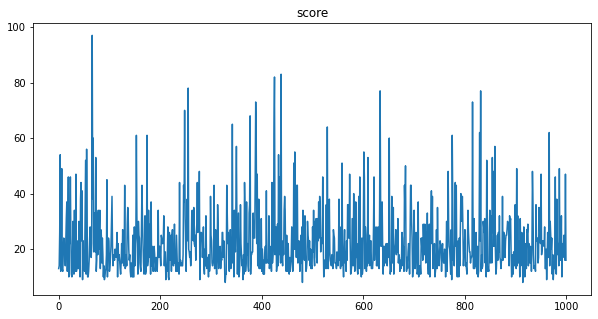

In [6]:
from QLearning.dqn.run import run_episode, run_experiment

# Cell to train the agent. If you want to load the weights, skip this cell.

agent = RandomAgent(env.action_space.n)

run_experiment(env, agent, runs=1000,
               plot_stats=[
                   'score',
               ], 
              plot_period=50)
env.close()

In [ ]:
## GOOGLE COLAB
import base64
import io
import gym
from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start()

env = Monitor(gym.make('CartPole-v1'), './random_control', force=True)

obs = env.reset()
done = False
while not done:
    obs, reward, done, info = env.step(agent.compute_action(obs))

    if done:
        env.reset()

for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))
env.close()

In [14]:
import os
from gym import wrappers
from IPython.display import Video

video_path = "Experiments/random_agent_cartpole"

eval_env = wrappers.Monitor(env, video_path, force=True)

print(run_episode(eval_env, agent))

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name), embed=True)

C:\Users\ikayn\anaconda3\envs\rl_env\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))


{'score': 29.0, 'steps_per_game': 29, 'framerate': 23.500260715216886}


## EpsilonGreedyAgent

In [9]:
class EpsilonGreedyAgent(Agent):
    def __init__(self,
                 n_actions,
                 network=None,
                 gamma=0.99,
                 batch_size=32,
                 replay_capacity=10000,
                 training_start=50,  # start training after x number of steps
                 training_interval=4,  # train every x steps
                 start_epsilon=1.0,
                 end_epsilon=0.02,
                 epsilon_decay=5e-6,
                 ):

        self.n_actions = n_actions
        self.network = network

        self.replay_buffer = ReplayBuffer(replay_capacity)

        self.epsilon = start_epsilon
        self.max_epsilon = start_epsilon
        self.min_espilon = end_epsilon
        self.epsilon_decay = epsilon_decay

        self.batch_size = batch_size
        self.gamma = gamma

        self.steps = 0
        self.runs = 0
        self.return_ = 0

        self.training_start = training_start
        self.training_interval = training_interval

        self.episode_losses = []

    def compute_action(self, obs):
        """
        Given the state return the action following epsilon-greedy strategy
        :param
            state (array_like): state of the system
        :return(int): action
        """
        if self.network is None:
            message = 'The network is not set. Please, create with Agent(network=network) or use agent.load()'
            print(message)
            raise ValueError()

        # When observation is missing the batch dimension add it
        if len(obs.shape) == 1:
            obs = np.expand_dims(obs, axis=0)

        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_actions)
        else:
            action = self.network.get_best_action(obs)
            # Since this get_best_action() returns a tensor
            # we convert it to numpy and then to the Python int
            action = action.numpy().item()

        return action

    def update(self, current_state, action, reward, next_state, is_terminal):
        """
        Append the transition to a replay buffer and train the network if necessary
        :param current_state: (array_like)
        :param action: (int)
        :param reward: (float)
        :param next_state: (array_like)
        :param is_terminal: (float)
        :return: loss of the network
        """
        self.return_ = reward + self.gamma * self.return_
        self.replay_buffer.store((
            current_state,
            action,
            np.asarray(reward, dtype='float32'), # gym returns float64
            next_state,
            np.asarray(is_terminal, dtype='float32'))
        )

        loss = 0
        train_network = self.training_start < self.steps and self.steps % self.training_interval == 0
        if train_network:
            sample_batch = self.replay_buffer.sample_batch(self.batch_size)
            loss = self.network.update(*sample_batch)
            self.episode_losses.append(loss)
        self.steps += 1

        return loss

    def finalize_episode(self):
        """
        Clear score, return episode statistics values. Update epsilon. Save the model if necessary.
        :return: agents statistics per episode
        """
        stats = {}

        stats['runs'] = self.runs
        self.runs += 1

        # reset episode return
        stats['return'] = self.return_
        self.return_ = 0

        # update exploration
        stats['epsilon'] = self.epsilon
        self.update_epsilon(self.steps)

        # get mean of the losses for this episode
        loss = np.mean(self.episode_losses) if self.episode_losses else 0
        stats['loss'] = loss
        self.episode_losses = []

        stats['steps'] = self.steps

        return stats

    def update_epsilon(self, time_step):
        """
        Update epsilon value based on the time-step
        :param time_step: current timestep
        :return:
        """
        self.epsilon = self.min_espilon + \
                       (self.max_epsilon - self.min_espilon) \
                       * math.exp(-self.epsilon_decay * time_step)

## Annealing Epsilon Value

We are going to anneal the epsilon value from 1.0 to 0.02 with this formula.
$$\varepsilon = \varepsilon_{min} + (\varepsilon_{max} - \varepsilon_{min}) * exp(-\varepsilon_{decay} * t)$$, where $t$ is the current timestep. In most of the papers the training lasts until 200 million frames. CartPole, however is a bit easier game, so we don't need to explore for too long. We are going to train for approx. 50 000 frames, therefore $\varepsilon_{decay}$ should be $5 * 10^{-4}$ to make sure that the agent explores actively for at least half of that time. We can see the exploration value on the plot bellow.

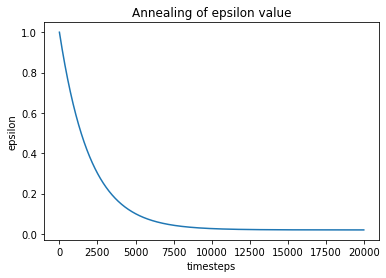

In [10]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def update_epsilon(time_step, min_epsilon, max_epsilon, epsilon_decay):

    epsilon = min_epsilon + \
                   (max_epsilon - min_epsilon) \
                   * math.exp(-epsilon_decay * time_step)
    return epsilon

# These values will nicely decrease epsilon value to 0.02 within a million timesteps.
# For games harder even smaller epsilon decay values are used.
start_epsilon = 1.0
end_epsilon = 0.02
epsilon_decay = 5e-4

total_timesteps = 5e6

timesteps = np.linspace(0, 20000, 1000)
epsilon_values = [update_epsilon(t, end_epsilon, start_epsilon, epsilon_decay) for t in timesteps]
ax = sns.lineplot(x=timesteps, y=epsilon_values)
ax.set(xlabel='timesteps', ylabel='epsilon')
plt.title('Annealing of epsilon value')
plt.show()

We are going to reuse some of the code from the previous notebook. Such as `run_episode()` and `run_experiment()`

In [23]:
import gym

env = gym.make('CartPole-v0') # Max number of steps: 200
# env = gym.make('CartPole-v1') # Max number of steps: 500

print('Observation space:', env.observation_space)
print('Action space:', env.action_space)

Observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space: Discrete(2)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class DeepQNetwork:
    def __init__(
        self,
        state_shape,
        n_actions,
        learning_rate=1e-4,
        gamma=0.99,
    ):
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.online_network = self.create_model("dqn")

        self.gamma = tf.constant(gamma)

        self.loss_layer = tf.keras.losses.Huber()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    def create_model(self, model_name):
        input_obs = tf.keras.Input(
            shape=self.state_shape, name="obs_input", dtype=tf.float32
        )
        x = ...
        # last layer with self.n_actions units and linear activations
        q_values = Dense(self.n_actions, activation='linear')(x) #---YOUR CODE HERE---#

        q_network = Model(inputs=[input_obs], outputs=[q_values], name=model_name)
        return q_network

    @tf.function
    def get_best_action(self, state):
        return tf.argmax(self.online_network(state), axis=1) # (32, 2)

    @tf.function
    def get_best_action_value(self, state):
        return tf.reduce_max(self.online_network(state), axis=1)

    @tf.function
    def train_op(
        self, replay_state, replay_action, replay_rewards, replay_next_state, terminal
    ):
        
        replay_continues = 1.0 - terminal
        # get max q-values for the next state
        q_best_next = ... #---YOUR CODE HERE---#
        # calculate target, if episode is over do not add next q-values to the target
        y_val = ... #---YOUR CODE HERE---#
        with tf.GradientTape() as tape:
            # calculate current q-values
            q_values = self.online_network(replay_state)
            # get the q-values of the executed actions
            q_values_masked = ... #---YOUR CODE HERE---#
            # calculate loss using self.loss_layer
            loss = ... #---YOUR CODE HERE---#
        # compute gradients
        gradients = tape.gradient(loss, self.online_network.trainable_variables)
        # apply gradients
        self.optimizer.apply_gradients(
            zip(gradients, self.online_network.trainable_variables)
        )
        return loss

    def update(self, *args, **kwargs):
        return self.train_op(*args, **kwargs)

In [29]:
q_network = DeepQNetwork(state_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                         learning_rate=0.00025,
                         gamma=0.95)

agent = EpsilonGreedyAgent(n_actions=env.action_space.n,
                   network=q_network,
                   replay_capacity=5000,
                   gamma=0.95,  # discount of future rewards
                   training_start=100,  # start training after x number of steps
                   training_interval=1,  # train every x steps
                   batch_size=32,
                   start_epsilon=1.0,
                   end_epsilon=0.02,
                   epsilon_decay=1e-4)

# Define history object to hold all statistics. Usefull if you want to continue training
history = {}

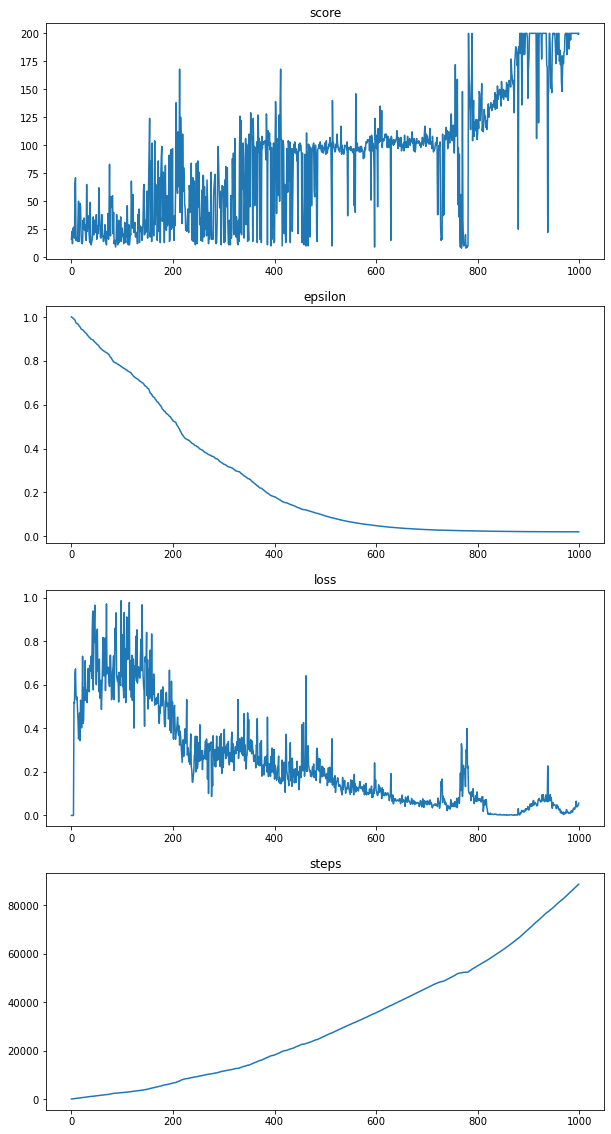

In [30]:
from QLearning.dqn.run import run_episode, run_experiment

history = run_experiment(env, agent, runs=1000, history=history,
               plot_stats=[
                   'score',
#                    'return',
#                    'steps_per_game',
                   'epsilon',
                   'loss',
#                    'framerate',
                   'steps'
               ], 
              plot_period=100)
env.close()

In [ ]:
## GOOGLE COLAB
import base64
import io
import gym
from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

d = Display()
d.start()

env = Monitor(gym.make('CartPole-v1'), './dqn_cartpole', force=True)

obs = env.reset()
done = False
while not done:
    obs, reward, done, info = env.step(agent.compute_action(obs))

    if done:
        env.reset()

for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))
env.close()

In [31]:
import os
from gym import wrappers
from IPython.display import Video

video_path = "Experiments/dqn_cartpole"

eval_env = wrappers.Monitor(env, video_path, force=True)

print(run_episode(eval_env, agent))

# take the last element in the folder with .mp4 extension
video_name = [x for x in os.listdir(video_path) if '.mp4' in x][-1]
Video(os.path.join(video_path, video_name), embed=True)

{'score': 189.0, 'steps_per_game': 189, 'framerate': 52.73643901345255, 'runs': 1000, 'return': 19.998767487321988, 'epsilon': 0.02013842211912026, 'loss': 0.0451355, 'steps': 88839}
